# Logistic Regression - Classifying Video Types

Logistic regression is a linear classifier that uses the same relationship that linear Regression uses, yet it predicts discrete classes instead of a continuous variable. Thus, where linear regression uses the relationship:

$$\hat{y} = b + w_1 x_1 + w_2 x_2 + ... + w_n x_n$$

Where $\hat{y}$ is the predicted value, $b$ is the y-intercept, $w_n$ is the slope, and $x_n$ is the feature data.

Logistic Regression returns a true false value using the same relationship by setting a threshold:

$$\hat{y} = b + w_1 x_1 + w_2 x_2 + ... + w_n x_n > 0$$

Thus if the predicted value is >1 we say the predicted data is in the expected class and if the predicted value is <1 we say the predicted data is NOT in the expected class. Logistic regression classifiers can be assessed in the same way other classifiers can be assessed using ROC curves, confusion matrices, etc. The strength of the coefficients can also be examined to understand which features are important to the model.

1. remake plots 2-15, remake plots 2-16 frmo intro to machine learning 
2. designate a scribe for the discussion
3. try to describe when and why we use logistic regression over something else
4. show different values for C

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pandas.plotting as pdplot
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn import metrics
import mglearn

In [2]:
df = pd.read_csv('data/lecture vs lab model.csv')
df['n_students'] = df['n_students']/df['n_students'].max()

In [3]:
df.describe()

,Video Order,Video Length (s),n_views,n_students,number_of_clicker_Qs,avg_time_watched,std_time_watched
count,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,39.500000,498.847692,241.820513,0.380203,1.102564,77.998901,32.510611
std,22.660538,215.116595,177.656369,0.188332,1.354068,8.779126,5.791795
min,1.000000,59.150000,67.000000,0.142857,0.000000,48.150106,16.705916
25%,20.250000,363.325000,129.500000,0.259740,0.000000,72.743365,28.876143
50%,39.500000,468.450000,169.500000,0.319805,1.000000,78.860843,33.056366
75%,58.750000,618.582500,279.000000,0.443994,2.000000,84.355745,36.097115
max,78.000000,1107.340000,801.000000,1.000000,6.000000,93.852066,42.977878


''

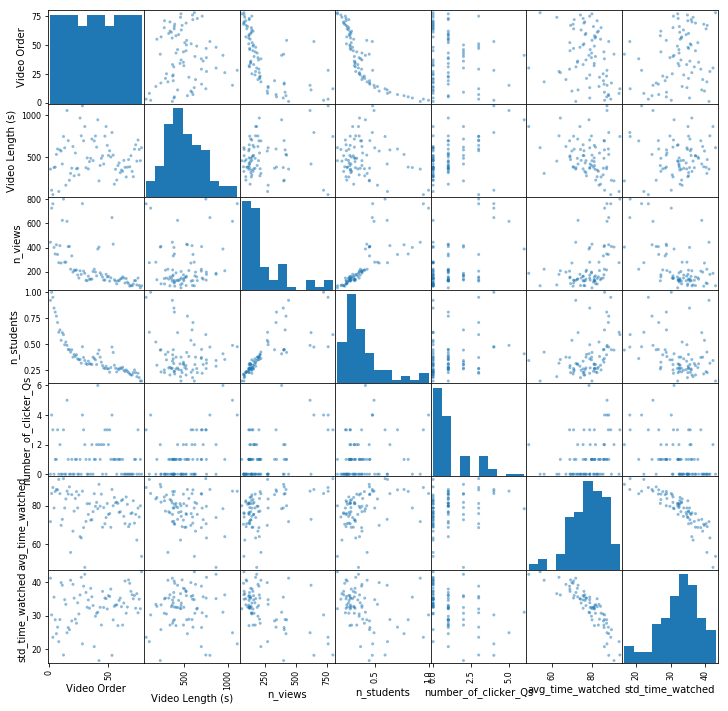

In [4]:
pdplot.scatter_matrix(df, alpha=0.5, figsize=(12, 12))
''

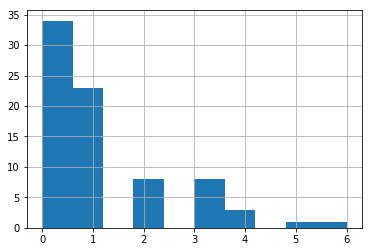

In [5]:
df['number_of_clicker_Qs'].hist()

## Dealing with number of clicker questions

Since it seems like the number of clicker questions isn't going to be a good feature to have multiple values, I've changed it to either be true or false

In [6]:
df['has_clicker_questions'] = df.apply(lambda row: 1 if row['number_of_clicker_Qs']>0 else 0, axis=1)

In [7]:
df.columns

Index(['Video Order', 'Title', 'Video Length (s)', 'video_type', 'n_views',
       'n_students', 'number_of_clicker_Qs', 'avg_time_watched',
       'std_time_watched', 'has_clicker_questions'],
      dtype='object')

In [8]:
LR = LogisticRegression()


In [9]:
example_df = df[['Video Order','video_type', 'n_views',]]

# train_ids = np.random.choice(df['Video Order'], 39)
train_ids = np.random.choice(example_df['Video Order'], 39)
# train = df[df['Video Order'].isin(train_ids)]
train = example_df[example_df['Video Order'].isin(train_ids)]
# test = df[~df['Video Order'].isin(train_ids)]
test = example_df[~example_df['Video Order'].isin(train_ids)]

In [10]:
features = ['Video Order','n_views',]

train_x = train[features]
train_y = train['video_type']

In [11]:
test_x = test[features]
test_y = test['video_type']

In [12]:
lrfit = LR.fit(train_x, train_y)

In [13]:
lrfit.score(test_x, test_y)

0.81395348837209303

In [14]:
predictions = LR.predict(test_x)

In [15]:
 metrics.confusion_matrix(test_y, predictions)

array([[ 2,  6],
       [ 2, 33]])

In [16]:
predict_prob = lrfit.predict_proba(test_x)

In [17]:
rocdf = pd.DataFrame({'test':test_y})
rocdf['test_bin'] = rocdf.apply(lambda row: 1 if row['test']=='lab video' else 0, axis=1)

fpr, tpr, thresholds = metrics.roc_curve(rocdf['test_bin'], predict_prob[:,1])

Text(0.5,0,'False Positive Rate')

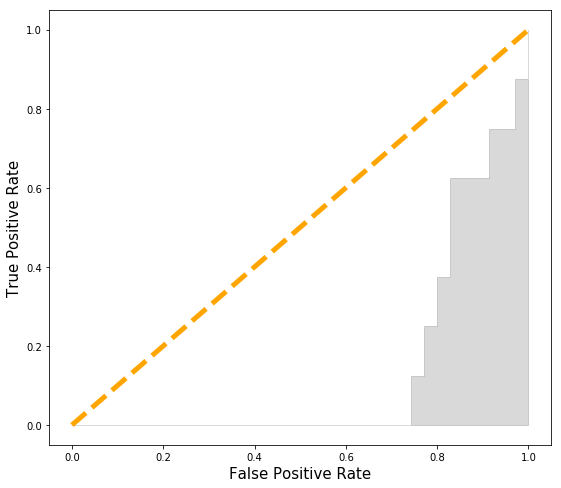

In [18]:
fig, ax = plt.subplots(figsize=(9, 8))

# for f,t in zip(fprs, tprs):
ax.fill_between(fpr, 0, tpr, color='black', alpha=0.15)
    
ax.plot([0, 1], [0, 1], color='orange', linestyle='--', linewidth=5)
ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)

(-0.5, 6.5)

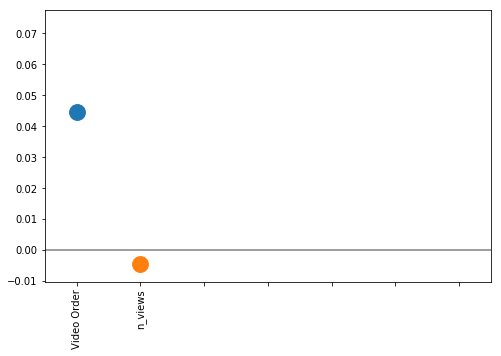

In [19]:
fig, ax = plt.subplots(figsize=(8, 5))

for n in range(2):
    ax.scatter(n, lrfit.coef_[0][n], s=250)

ax.set_xticks(np.arange(0, 7))
ax.set_xticklabels(features, rotation=90)

ax.plot([-1, 8], [0, 0], color='black', alpha=0.5)
ax.set_xlim(-0.5, 6.5)

In [20]:
markers = df[df['Video Order'].isin(test_x['Video Order'])]['video_type'].apply(lambda row: 'x' if row=='lecture video' else '^')

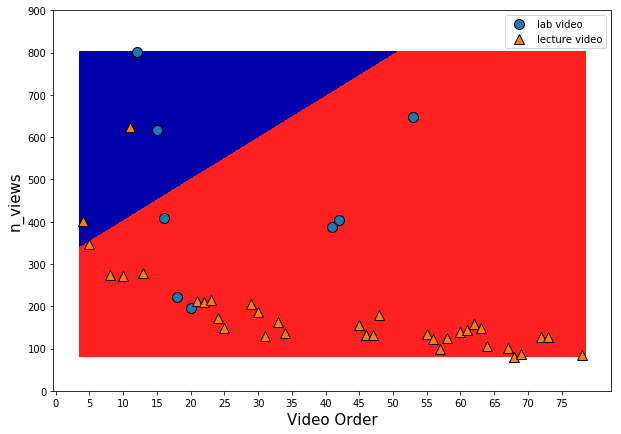

In [21]:
fig, ax = plt.subplots(figsize=(10, 7))

xvalues = test_x.values[:,0:3]
mglearn.plots.plot_2d_separator(lrfit, xvalues, fill=True, eps=0.5, ax=ax)
mglearn.discrete_scatter(xvalues[:,0], xvalues[:,1], y=markers,  ax=ax)

ax.set_ylabel('n_views', fontsize=15)
ax.set_xlabel('Video Order', fontsize=15)

ax.set_xticks(np.arange(0, 80, 5))
ax.set_yticks(np.arange(0, 1000, 100))
ax.legend(['lab video', 'lecture video'])

## Here we set equal number lab and lecture videos for the model

This makes it so it isn't just classifying everything as lecture since there are 14 lab videos and 64 lecture videos.

In [22]:
not_r_squareds = []
coefs = []
run = []
for n in np.arange(1000):

    lecture_id_train = np.random.choice(df[df['video_type']=='lecture video']['Video Order'], 5)
    lab_id_train = np.random.choice(df[df['video_type']=='lab video']['Video Order'], 5)
    train_ids = np.concatenate([lecture_id_train, lab_id_train])

    train = df[df['Video Order'].isin(train_ids)]
    test = df[~df['Video Order'].isin(train_ids)]

    features = ['Video Order','Video Length (s)', 'n_views',
           'n_students', 'avg_time_watched',
           'std_time_watched', 'has_clicker_questions']

    train_x = train[features]
    train_y = train['video_type']

    test_x = test[features]
    test_y = test['video_type']

    LR2 = LogisticRegression(solver='liblinear')
    lrfit = LR2.fit(train_x, train_y)
    predictions = LR2.predict(test_x)

    not_r_squareds.append(lrfit.score(test_x, test_y))

    coefs.append(lrfit.coef_[0])
    
    run.append(n)

In [23]:
not_r_squareds = []
coefs = []
run = []
fprs = []
tprs = []
for n in np.arange(1000):

    lecture_id_train = np.random.choice(df[df['video_type']=='lecture video']['Video Order'], 5)
    lab_id_train = np.random.choice(df[df['video_type']=='lab video']['Video Order'], 5)
    train_ids = np.concatenate([lecture_id_train, lab_id_train])

    train = df[df['Video Order'].isin(train_ids)]
    test = df[~df['Video Order'].isin(train_ids)]

    features = ['Video Order','Video Length (s)', 'n_views',
           'n_students', 'avg_time_watched',
           'std_time_watched', 'has_clicker_questions']

    train_x = train[features]
    train_y = train['video_type']

    test_x = test[features]
    test_y = test['video_type']

    LR2 = LogisticRegression(solver='liblinear')
    lrfit = LR2.fit(train_x, train_y)
    predictions = LR2.predict(test_x)
    
    predict_prob = lrfit.predict_proba(test_x)

    rocdf = pd.DataFrame({'test':test_y})
    rocdf['test_bin'] = rocdf.apply(lambda row: 1 if row['test']=='lab video' else 0, axis=1)

    fpr, tpr, thresholds = metrics.roc_curve(rocdf['test_bin'], predict_prob[:,1])

    not_r_squareds.append(lrfit.score(test_x, test_y))

    coefs.append(lrfit.coef_[0])
    
    run.append(n)
    
    fprs.append(fpr)
    tprs.append(tpr)
    
coefs = np.array(coefs)

(-0.5, 6.5)

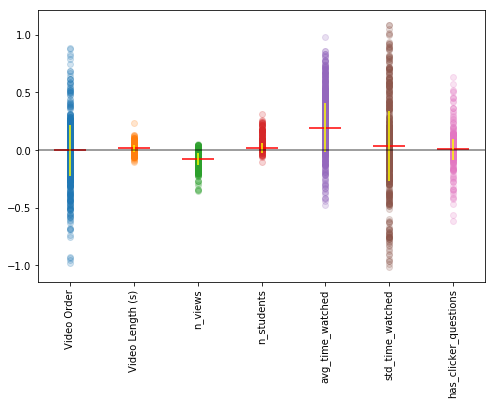

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))

for n in range(7):
    ax.scatter((n,)*1000, coefs[:,n], alpha=0.2)
    ax.scatter(n, np.mean(coefs[:,n]), s=1000, marker='_', color='red')
    ax.errorbar(x=n, y=np.mean(coefs[:,n]), yerr=np.std(coefs[:,n]), color='yellow')

ax.set_xticks(np.arange(0, 7))
ax.set_xticklabels(features, rotation=90)

ax.plot([-1, 8], [0, 0], color='black', alpha=0.5)
ax.set_xlim(-0.5, 6.5)

Text(0,0.5,'R-Score')

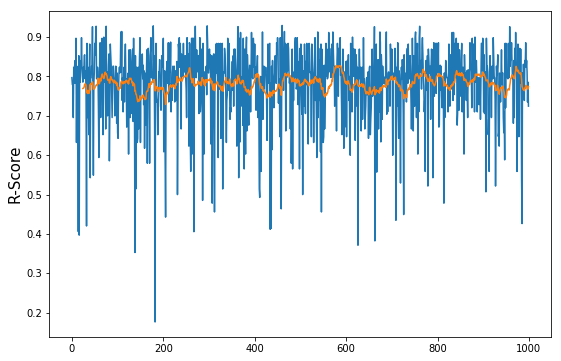

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(np.arange(1000), not_r_squareds)
ax.plot(pd.DataFrame(not_r_squareds).rolling(window=25).mean())
ax.set_ylabel('R-Score', fontsize=15)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 8))

for f,t in zip(fprs, tprs):
    ax.fill_between(f, 0, t, color='black', alpha=0.01)
    
ax.plot([0, 1], [0, 1], color='orange', linestyle='--', linewidth=5)
ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)

Text(0.5,0,'False Positive Rate')

In [ ]:
metrics.confusion_matrix(test_y, predictions)

# standard scale everything

Sometimes, models perform better when all the values are scaled together. Sklearn has a preprocessing library that can rescale your data to be on a normal (etc) scale. Here I use it to see if it will produce better model performance.

In [ ]:
scaled_df = pd.DataFrame(preprocessing.scale(df[features]), columns=features)

In [ ]:
pdplot.scatter_matrix(scaled_df, figsize=(16, 16))
''

In [ ]:
df.columns

In [ ]:
scaled_df = df.join(scaled_df, lsuffix='_df')[df.columns]

In [ ]:
not_r_squareds = []
coefs = []
run = []
fprs = []
tprs = []
for n in np.arange(1000):

    lecture_id_train = np.random.choice(scaled_df[scaled_df['video_type']=='lecture video']['Video Order'], 5)
    lab_id_train = np.random.choice(scaled_df[scaled_df['video_type']=='lab video']['Video Order'], 5)
    train_ids = np.concatenate([lecture_id_train, lab_id_train])

    train = scaled_df[scaled_df['Video Order'].isin(train_ids)]
    test = scaled_df[~scaled_df['Video Order'].isin(train_ids)]

    features = ['Video Order','Video Length (s)', 'n_views',
           'n_students', 'avg_time_watched',
           'std_time_watched', 'has_clicker_questions']

    train_x = train[features]
    train_y = train['video_type']

    test_x = test[features]
    test_y = test['video_type']

    LR2 = LogisticRegression(solver='liblinear')
    lrfit = LR2.fit(train_x, train_y)
    predictions = LR2.predict(test_x)
    
    predict_prob = lrfit.predict_proba(test_x)

    rocdf = pd.DataFrame({'test':test_y})
    rocdf['test_bin'] = rocdf.apply(lambda row: 1 if row['test']=='lab video' else 0, axis=1)

    fpr, tpr, thresholds = metrics.roc_curve(rocdf['test_bin'], predict_prob[:,1])

    not_r_squareds.append(lrfit.score(test_x, test_y))

    coefs.append(lrfit.coef_[0])
    
    run.append(n)
    
    fprs.append(fpr)
    tprs.append(tpr)
    
coefs = np.array(coefs)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

for n in range(7):
    ax.scatter((n,)*1000, coefs[:,n], alpha=0.2)
    ax.scatter(n, np.mean(coefs[:,n]), s=1000, marker='_', color='red')
    ax.errorbar(x=n, y=np.mean(coefs[:,n]), yerr=np.std(coefs[:,n]), color='yellow')

ax.set_xticks(np.arange(0, 7))
ax.set_xticklabels(features, rotation=90)

ax.plot([-1, 8], [0, 0], color='black', alpha=0.5)
ax.set_xlim(-0.5, 6.5)

In [ ]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(np.arange(1000), not_r_squareds)
ax.plot(pd.DataFrame(not_r_squareds).rolling(window=25).mean())
ax.set_ylabel('R-Score', fontsize=15)

In [ ]:
fig, ax = plt.subplots(figsize=(9, 8))

for f,t in zip(fprs, tprs):
    ax.fill_between(f, 0, t, color='black', alpha=0.01)
    
ax.plot([0, 1], [0, 1], color='orange', linestyle='--', linewidth=5)
ax.set_ylabel('True Positive Rate', fontsize=15)
ax.set_xlabel('False Positive Rate', fontsize=15)